In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb 
import lightgbm as lgbm
# from catboost import CatBoostClassifier
import catboost as catb


# from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from IPython.display import Image

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

In [2]:
TRAIN_PART_PATH = './train.csv'
PREPARED_DATASET_PATH = './train_prepared.csv'
TEST_PART_PATH = './test.csv'

In [3]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        self.medians = df[['Annual Income', 'Credit Score', 'Months since last delinquent']].median()
        self.mode_1 = df['Years in current job'].mode()[0]
        self.mode_2 = df['Bankruptcies'].mode()[0]

        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1.1 Пропуски float
        df[['Annual Income', 'Credit Score', 'Months since last delinquent']] =\
        df[['Annual Income', 'Credit Score', 'Months since last delinquent']].fillna(self.medians)
        
        # 1.2 Пропуски object
        
        df['Years in current job'].fillna(self.mode_1, inplace=True)
        df['Bankruptcies'].fillna(self.mode_2, inplace=True)
        
        # 2. Выбросы (outliers)
        
        df.loc[df['Credit Score'] > 6000, 'Credit Score'] = df['Credit Score'].median()
        df.loc[df['Credit Score'] < 650, 'Credit Score'] = df['Credit Score'].median()
#         df.loc[(df['Maximum Open Credit'] >  1e6) | (df['Maximum Open Credit'] == 0), 'Maximum Open Credit'] = df['Maximum Open Credit'].median()
# #         df.loc[df['Number of Credit Problems'] > 1 , 'Number of Credit Problems'] = 1
#         df.loc[df['Months since last delinquent'] > 40, 'Months since last delinquent'] = df['Months since last delinquent'].median()
#         df.loc[(df['Monthly Debt'] > 50000) |  (df['Monthly Debt'] < 1e3), 'Monthly Debt'] = df['Monthly Debt'].median()
        df.loc[df['Current Loan Amount'] > 1e7, 'Current Loan Amount'] = df['Current Loan Amount'].median()
        df.loc[df['Years of Credit History'] > 25, 'Years of Credit History'] = df['Years of Credit History']. median()
        df.loc[df['Number of Open Accounts'] > 20, 'Number of Open Accounts'] = df['Number of Open Accounts'].median()
#         df.loc[df['Tax Liens'] > 2, 'Tax Liens'] = 2
#         df.loc[df['Bankruptcies'] > 2, 'Bankruptcies'] = 2
        df.loc[(df['Current Credit Balance'] > 1e6), 'Current Credit Balance'] = df['Current Credit Balance'].median()
#         df.loc[(df['Current Credit Balance'] == 0), 'Current Credit Balance'] = df['Current Credit Balance'].median()
#         ######################################
        
        # 3. Новые фичи (features)
        
        #Доля кредита в годовом доходе
#         df['annual_credit_share'] = df['Maximum Open Credit'] / df['Annual Income']
        
        #Доля текущего баланса в текущей задолженности
        df['current_balance_share'] = df['Current Credit Balance'] / df['Current Loan Amount']
        
        
        ########################################
        
        df_cat = df.groupby(['Home Ownership', 'Years in current job'], as_index=False).median()[['Home Ownership', 'Years in current job', 'Maximum Open Credit']]
        df_cat = pd.DataFrame(df_cat)
        df_cat.rename(columns={'Maximum Open Credit': 'median_Maximum Open Credit'}, inplace=True)
        df = df.merge(df_cat, on=['Home Ownership', 'Years in current job'])
        
        return df

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [7]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [8]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [9]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [10]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [11]:
df_train = pd.read_csv(TRAIN_PART_PATH, sep=',')

pipe = DataPipeline()
pipe.fit(df_train)
df_train = pipe.transform(df_train)

# Home_Ownership_cat(df_train)
# Years_in_current_job_cat(df_train)
# Purpose_cat(df_train)
# Term_cat(df_train)
# Month_cat(df_train)
df_train.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')
df_train

Home Ownership  Annual Income Years in current job  Tax Liens  \
0          Own Home       482087.0            10+ years        0.0   
1          Own Home      1025487.0            10+ years        0.0   
2          Own Home      1168386.0            10+ years        0.0   
3          Own Home      1168386.0            10+ years        0.0   
4          Own Home      1289796.0            10+ years        0.0   
...             ...            ...                  ...        ...   
7495       Own Home      1418160.0              9 years        0.0   
7496       Own Home       664012.0              9 years        0.0   
7497  Have Mortgage      1111728.0              6 years        0.0   
7498  Have Mortgage      1160463.0              3 years        0.0   
7499  Have Mortgage      1168386.0              5 years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                        11.0                     17.0             685960.0   
1                        15.0                     15.3            1181730.0   
2                        17.0                     14.8             700040.0   
3                        12.0                     25.0            1216336.0   
4                        11.0                     20.5             845548.0   
...                       ...                      ...                  ...   
7495                      9.0                     21.4             256256.0   
7496                      8.0                     16.9             232738.0   
7497                     10.0                     15.1             173866.0   
7498                     10.0                     20.6             839938.0   
7499                      6.0                     14.3             400136.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                           1.0                          32.0           1.0   
1                           0.0                          32.0           0.0   
2                           0.0                          17.0           0.0   
3                           0.0                          61.0           0.0   
4                           0.0                          32.0           0.0   
...                         ...                           ...           ...   
7495                        1.0                          32.0           1.0   
7496                        1.0                          38.0           1.0   
7497                        0.0                          14.0           0.0   
7498                        1.0                          32.0           1.0   
7499                        0.0                          42.0           0.0   

                 Purpose        Term  Current Loan Amount  \
0     debt consolidation  Short Term             309573.0   
1     debt consolidation   Long Term             264968.0   
2     debt consolidation  Short Term             174878.0   
3     debt consolidation  Short Term             467676.0   
4     debt consolidation   Long Term             309573.0   
...                  ...         ...                  ...   
7495  debt consolidation  Short Term             218944.0   
7496  debt consolidation  Short Term             219670.0   
7497         take a trip  Short Term             102982.0   
7498         take a trip  Short Term             130240.0   
7499         take a trip  Short Term              64878.0   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default  \
0                    47386.0        7914.0         749.0               0   
1                   394972.0       18373.0         737.0               1   
2                   168074.0       17132.0         731.0               1   
3                   818311.0       37530.0         731.0               0   
4                   640433.0       26549.0         708.0               0   
...                      ...           ...           ...             ...   
7

In [12]:
df_test = pd.read_csv(TEST_PART_PATH, sep=',')
pipe = DataPipeline()
pipe.fit(df_test)
df_test = pipe.transform(df_test)

# Home_Ownership_cat(df_test)
# Years_in_current_job_cat(df_test)
# Purpose_cat(df_test)
# Term_cat(df_test)
# Month_cat(df_test)
df_test.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')
df_test.tail(10)

Home Ownership  Annual Income Years in current job  Tax Liens  \
2490       Own Home       880897.0               1 year        0.0   
2491       Own Home      1822537.0               1 year        0.0   
2492       Own Home       501904.0               1 year        0.0   
2493       Own Home      1259947.0               1 year        0.0   
2494       Own Home      1178475.0               1 year        0.0   
2495       Own Home       568746.0               1 year        0.0   
2496  Have Mortgage      1178475.0              4 years        0.0   
2497  Have Mortgage      1053987.0              4 years        0.0   
2498  Have Mortgage      3182652.0              3 years        0.0   
2499  Have Mortgage      1071315.0               1 year        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
2490                      7.0                     17.2             161832.0   
2491                      6.0                     14.4             369468.0   
2492                      9.0                     12.1            1368488.0   
2493                      3.0                     19.1             157168.0   
2494                     14.0                     22.0            1039522.0   
2495                      8.0                     17.0             366498.0   
2496                     13.0                     14.1             605132.0   
2497                     11.0                     12.0             124146.0   
2498                      7.0                     21.6             660792.0   
2499                      6.0                     21.7             240658.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
2490                        0.0                          14.0           0.0   
2491                        0.0                          11.0           0.0   
2492                        0.0                           7.0           0.0   
2493                        0.0                          30.0           0.0   
2494                        0.0                          30.0           0.0   
2495                        0.0                          50.0           0.0   
2496                        0.0                          58.0           0.0   
2497                        0.0                           4.0           0.0   
2498                        0.0                          30.0           0.0   
2499                        0.0                          44.0           0.0   

                 Purpose        Term  Current Loan Amount  \
2490  debt consolidation  Short Term             205106.0   
2491  debt consolidation  Short Term             175868.0   
2492  debt consolidation  Short Term             203258.0   
2493               other  Short Term              40392.0   
2494  debt consolidation   Long Term             756536.0   
2495  debt consolidation  Short Term             175604.0   
2496         take a trip  Short Term             224158.0   
2497         take a trip  Short Term              33286.0   
2498         take a trip  Short Term             178684.0   
2499         take a trip  Short Term              76450.0   

      Current Credit Balance  Monthly Debt  Credit Score  \
2490                 88749.0        3259.0         717.0   
2491                246335.0       32198.0         731.0   
2492                224561.0        9871.0         717.0   
2493                 85785.0        2698.0         706.0   
2494                570988.0       41971.0         731.0   
2495                220932.0        8010.0         722.0   
2496                278027.0       32756.0         731.0   
2497                 47063.0       17478.0         731.0   
2498                 86735.0        9150.0         738.0   
2499                  8322.0         929.0         740.0   

      current_balance_share  median_Maximum Open Credit  
2490               0.432698                    332761.0  
2491               1.400681                  

In [13]:
pd.get_dummies(df_train['Years in current job'])
df_train = pd.concat([df_train, pd.get_dummies(df_train['Years in current job'])], axis=1)
pd.get_dummies(df_test['Years in current job'])
df_test = pd.concat([df_test, pd.get_dummies(df_test['Years in current job'])], axis=1)

In [14]:
pd.get_dummies(df_train['Home Ownership'])
df_train = pd.concat([df_train, pd.get_dummies(df_train['Home Ownership'])], axis=1)
pd.get_dummies(df_test['Home Ownership'])
df_test = pd.concat([df_test, pd.get_dummies(df_test['Home Ownership'])], axis=1)

In [15]:
pd.get_dummies(df_train['Purpose'])
df_train = pd.concat([df_train, pd.get_dummies(df_train['Purpose'])], axis=1)
pd.get_dummies(df_test['Purpose'])
df_test = pd.concat([df_test, pd.get_dummies(df_test['Purpose'])], axis=1)

In [16]:
pd.get_dummies(df_train['Term'])
df_train = pd.concat([df_train, pd.get_dummies(df_train['Term'])], axis=1)
pd.get_dummies(df_test['Term'])
df_test = pd.concat([df_test, pd.get_dummies(df_test['Term'])], axis=1)

In [17]:
df_train

Home Ownership  Annual Income Years in current job  Tax Liens  \
0          Own Home       482087.0            10+ years        0.0   
1          Own Home      1025487.0            10+ years        0.0   
2          Own Home      1168386.0            10+ years        0.0   
3          Own Home      1168386.0            10+ years        0.0   
4          Own Home      1289796.0            10+ years        0.0   
...             ...            ...                  ...        ...   
7495       Own Home      1418160.0              9 years        0.0   
7496       Own Home       664012.0              9 years        0.0   
7497  Have Mortgage      1111728.0              6 years        0.0   
7498  Have Mortgage      1160463.0              3 years        0.0   
7499  Have Mortgage      1168386.0              5 years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                        11.0                     17.0             685960.0   
1                        15.0                     15.3            1181730.0   
2                        17.0                     14.8             700040.0   
3                        12.0                     25.0            1216336.0   
4                        11.0                     20.5             845548.0   
...                       ...                      ...                  ...   
7495                      9.0                     21.4             256256.0   
7496                      8.0                     16.9             232738.0   
7497                     10.0                     15.1             173866.0   
7498                     10.0                     20.6             839938.0   
7499                      6.0                     14.3             400136.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                           1.0                          32.0           1.0   
1                           0.0                          32.0           0.0   
2                           0.0                          17.0           0.0   
3                           0.0                          61.0           0.0   
4                           0.0                          32.0           0.0   
...                         ...                           ...           ...   
7495                        1.0                          32.0           1.0   
7496                        1.0                          38.0           1.0   
7497                        0.0                          14.0           0.0   
7498                        1.0                          32.0           1.0   
7499                        0.0                          42.0           0.0   

      ... medical bills moving  other  renewable energy  small business  \
0     ...             0      0      0                 0               0   
1     ...             0      0      0                 0               0   
2     ...             0      0      0                 0               0   
3     ...             0      0      0                 0               0   
4     ...             0      0      0                 0               0   
...   ...           ...    ...    ...               ...             ...   
7495  ...             0      0      0                 0               0   
7496  ...             0      0      0                 0               0   
7497  ...             0      0      0                 0               0   
7498  ...             0      0      0                 0               0   
7499  ...             0      0      0                 0               0   

      take a trip  vacation  wedding  Long Term  Short Term  
0               0         0        0          0           1  
1               0         0        0          1           0  
2               0         0        0          0           1  
3               0         0        0          0           1  
4               0         0        0          1        

In [18]:
# df_train = reduce_mem_usage(df_train)

In [19]:
# df_test = reduce_mem_usage(df_test)

In [20]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME, 'Home Ownership' ,'Years in current job', 
                                    'Purpose','Months since last delinquent', 'Term', 'renewable energy', '10+ years', 
                                            '< 1 year']).tolist()

# NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Number of Credit Problems',
#                      'Current Loan Amount',
#                      'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'annual_credit_share', 'current_balance_share',
#                      'median_Maximum Open Credit']
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Number of Credit Problems',
                     'Current Loan Amount',
                     'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'current_balance_share',
                     'median_Maximum Open Credit']
CAT_FEATURE_NAMES = ['1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years',
                    '8 years', '9 years', 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent', 
                    'business loan', 'buy a car', 'buy house', 'debt consolidation', 'educational expenses', 
                    'home improvements', 'major purchase', 'medical bills', 'moving', 'other', 'small business',
                    'small business', 'take a trip', 'vacation', 'wedding', 'Long Term', 'Short Term']

In [21]:
X = df_train.drop(columns=[TARGET_NAME, 'Home Ownership', '< 1 year','renewable energy','10+ years', 'Years in current job', 
                                    'Purpose','Months since last delinquent', 'Term', 'renewable energy'])
y = df_train[TARGET_NAME]

X_train = df_train.drop(columns=[TARGET_NAME, 'Home Ownership', '< 1 year', '10+ years', 'renewable energy', 'Years in current job', 
                                    'Purpose','Months since last delinquent', 'Term', 'renewable energy'])
y_train = df_train[TARGET_NAME]

# X_test = df_test.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
# y_test = df_test[TARGET_NAME]

In [22]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
    
df_balanced[TARGET_NAME].value_counts()

1    5387
0    5387
Name: Credit Default, dtype: int64

In [23]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

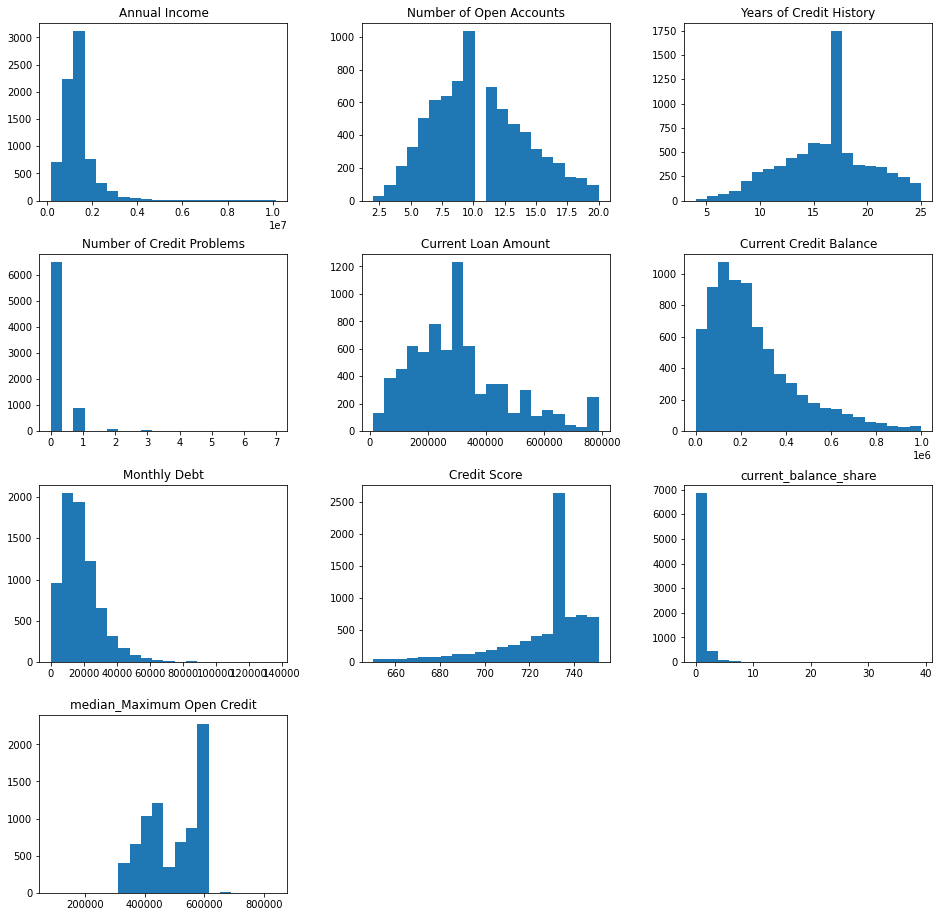

In [24]:
df_train[NUM_FEATURE_NAMES].hist(figsize=(16,16), bins=20, grid=False);

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler


def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=[target_col, 'Home Ownership' ,'Years in current job', 
                                    'Purpose','Months since last delinquent', 'Term'])
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.33,
                                                        shuffle=True,
                                                        random_state=21)
    
    model = RandomForestRegressor(n_estimators=50,
                                  max_depth=7,
                                  random_state=21,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=[target_col, 'Home Ownership' ,'Years in current job', 
                                    'Purpose','Months since last delinquent', 'Term']))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [26]:
df_copy = df_train.copy()
# df_test_copy = df_test.copy()

In [27]:
df_copy.isna().sum().sum()

0

In [28]:
def preprocess_outlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

feature_name = 'current_balance_share'
df_copy = preprocess_outlier(df_copy, feature_name, threshold=5)
# df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=5)

df_copy[feature_name].isna().sum()

109

In [29]:
%%time
current_balance_share_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9949951817053571
r2 на test: 0.9906525551336539
Wall time: 1.63 s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [30]:
df_copy[feature_name].isna().sum()

0

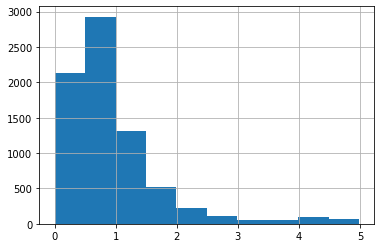

In [31]:
df_copy[feature_name].hist();

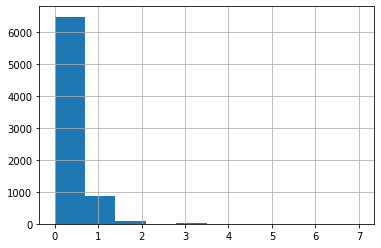

In [32]:
feature_name = 'Number of Credit Problems'
df_copy[feature_name].hist();

In [33]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=3)
# df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=3)

df_copy[feature_name].isna().sum()

21

In [34]:
current_balance_share_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9131296386957943
r2 на test: 0.8350076572981211


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


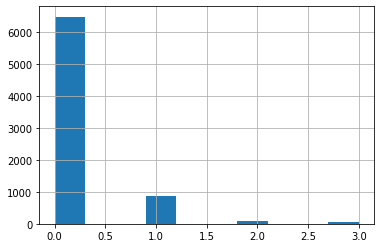

In [35]:
df_copy[feature_name].hist();

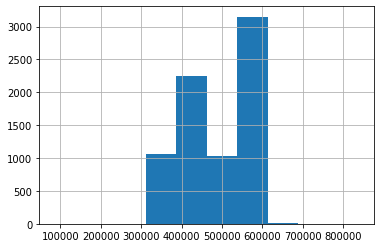

In [36]:
feature_name = 'median_Maximum Open Credit'
df_copy[feature_name].hist();

In [37]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=600000)
# df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=550000)

df_copy[feature_name].isna().sum()

6

In [38]:
current_balance_share_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9914030843280364
r2 на test: 0.9738966771699004


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


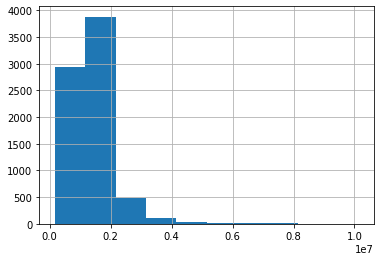

In [39]:
feature_name = 'Annual Income'
df_copy[feature_name].hist();

In [40]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=0.4 * 10**7)
# df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=550000)

df_copy[feature_name].isna().sum()

91

In [41]:
current_balance_share_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.5996988694763998
r2 на test: 0.37382511395856055


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


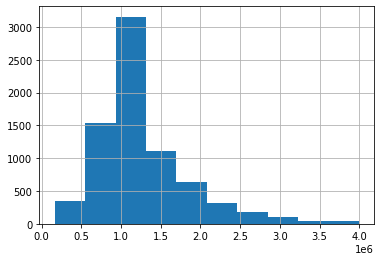

In [42]:
df_copy[feature_name].hist();

In [43]:
df_copy = df_test.copy()

In [44]:
feature_name = 'current_balance_share'
df_copy = preprocess_outlier(df_copy, feature_name, threshold=5)
# df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=5)

df_copy[feature_name].isna().sum()

39

In [45]:
%%time
current_balance_share_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9933743585156964
r2 на test: 0.9554542866907096
Wall time: 423 ms


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [46]:
df_copy[feature_name].isna().sum()

0

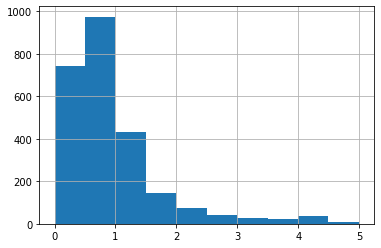

In [47]:
df_copy[feature_name].hist();

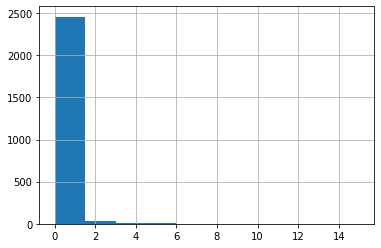

In [48]:
feature_name = 'Number of Credit Problems'
df_copy[feature_name].hist();

In [49]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=3)
# df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=3)

df_copy[feature_name].isna().sum()

7

In [50]:
current_balance_share_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9308977475205
r2 на test: 0.7443988975898661


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


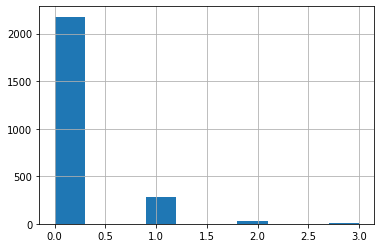

In [51]:
df_copy[feature_name].hist();

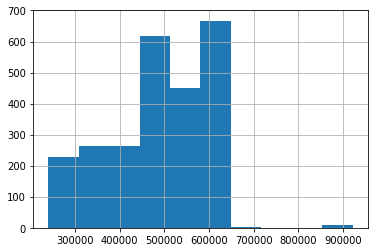

In [52]:
feature_name = 'median_Maximum Open Credit'
df_copy[feature_name].hist();

In [53]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=600000)
# df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=550000)

df_copy[feature_name].isna().sum()

676

In [54]:
current_balance_share_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


r2 на train: 0.993864650994006
r2 на test: 0.9930054847144285


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


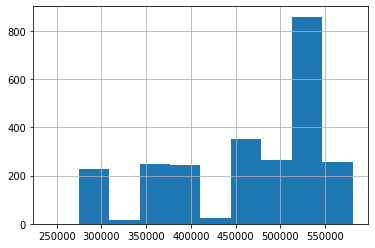

In [55]:
df_copy[feature_name].hist();

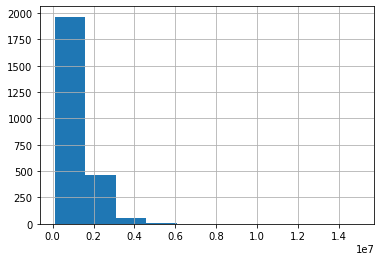

In [56]:
feature_name = 'Annual Income'
df_copy[feature_name].hist();

In [57]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=0.4 * 10**7)
# df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=550000)

df_copy[feature_name].isna().sum()

27

In [58]:
current_balance_share_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.666872109777528
r2 на test: 0.35209138369675064


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


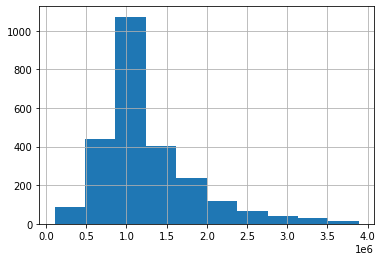

In [59]:
df_copy[feature_name].hist();

In [60]:
# scaler = StandardScaler()

# df_norm = df_train.copy()
# df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

# df_train = df_norm.copy()

In [61]:
# scaler = StandardScaler()

# df_norm = df_test.copy()
# df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

# df_test = df_norm.copy()

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)

In [63]:
model_lr = LogisticRegression(C=10,
                              max_iter=15
                              )
model_lr.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr, X_train_balanced, X_test, y_train_balanced, y_test)
model_lr.intercept_, model_lr.coef_.mean()

TRAIN

              precision    recall  f1-score   support

           0       0.57      0.57      0.57      5387
           1       0.57      0.57      0.57      5387

    accuracy                           0.57     10774
   macro avg       0.57      0.57      0.57     10774
weighted avg       0.57      0.57      0.57     10774

TEST

              precision    recall  f1-score   support

           0       0.75      0.56      0.64      1069
           1       0.33      0.54      0.41       431

    accuracy                           0.56      1500
   macro avg       0.54      0.55      0.53      1500
weighted avg       0.63      0.56      0.58      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               602  467
1               198  233


(array([2.22549149e-12]), 4.4864986919340134e-08)

In [64]:
%%time
model_svc_1 = SVC(C=10,
                kernel='rbf'
                )
model_svc_1.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc_1, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.61      0.43      0.50      5387
           1       0.56      0.73      0.63      5387

    accuracy                           0.58     10774
   macro avg       0.58      0.58      0.57     10774
weighted avg       0.58      0.58      0.57     10774

TEST

              precision    recall  f1-score   support

           0       0.79      0.44      0.57      1069
           1       0.34      0.70      0.45       431

    accuracy                           0.52      1500
   macro avg       0.56      0.57      0.51      1500
weighted avg       0.66      0.52      0.53      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               473  596
1               129  302
Wall time: 22.5 s


In [65]:
%%time
model_svc = SVC(C=1.5,
                kernel='poly',
                degree=2
                )
model_svc.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.04      0.07      5387
           1       0.50      0.98      0.67      5387

    accuracy                           0.51     10774
   macro avg       0.59      0.51      0.37     10774
weighted avg       0.59      0.51      0.37     10774

TEST

              precision    recall  f1-score   support

           0       0.89      0.04      0.07      1069
           1       0.29      0.99      0.45       431

    accuracy                           0.31      1500
   macro avg       0.59      0.51      0.26      1500
weighted avg       0.72      0.31      0.18      1500

CONFUSION MATRIX

col_0            0     1
Credit Default          
0               41  1028
1                5   426
Wall time: 19.2 s


In [66]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

[13:00:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      5387
           1       0.77      0.75      0.76      5387

    accuracy                           0.76     10774
   macro avg       0.76      0.76      0.76     10774
weighted avg       0.76      0.76      0.76     10774

TEST

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      1069
           1       0.47      0.49      0.48       431

    accuracy                           0.70      1500
   macro avg       0.63      0.64      0.63      1500
weighted avg       0.70      0.70      0.70      1500

CONFUSION MATRIX

col_0

In [67]:
params = {
    'reg_lambda': [0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10]
}

In [68]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [69]:
%%time
grid_search = GridSearchCV(param_grid=params, estimator=model_xgb, cv=cv, verbose=2, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)
display(grid_search.best_params_, grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] reg_lambda=0.2 ..................................................
[13:00:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... reg_lambda=0.2, total=   0.5s
[CV] reg_lambda=0.2 ..................................................
[13:00:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ................................... reg_lambda=0.2, total=   0.3s
[CV] reg_lambda=0.2 ..................................................
[13:00:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ................................... reg_lambda=0.2, total=   0.4s
[CV] reg_lambda=0.5 ..................................................
[13:00:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ................................... reg_lambda=0.5, total=   0.4s
[CV] reg_lambda=0.5 .....

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    9.0s finished


{'reg_lambda': 1.3}

0.7577634093822766

Wall time: 9.59 s


In [70]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=0.2
                             )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

[13:00:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      5387
           1       0.77      0.75      0.76      5387

    accuracy                           0.76     10774
   macro avg       0.76      0.76      0.76     10774
weighted avg       0.76      0.76      0.76     10774

TEST

              precision    recall  f1-score   support

           0       0.79      0.78      0.78      1069
           1       0.47      0.48      0.48       431

    accuracy                           0.69      1500
   macro avg       0.63      0.63      0.63      1500
weighted avg       0.70      0.69      0.69      1500

CONFUSION MATRIX

col_0

In [71]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

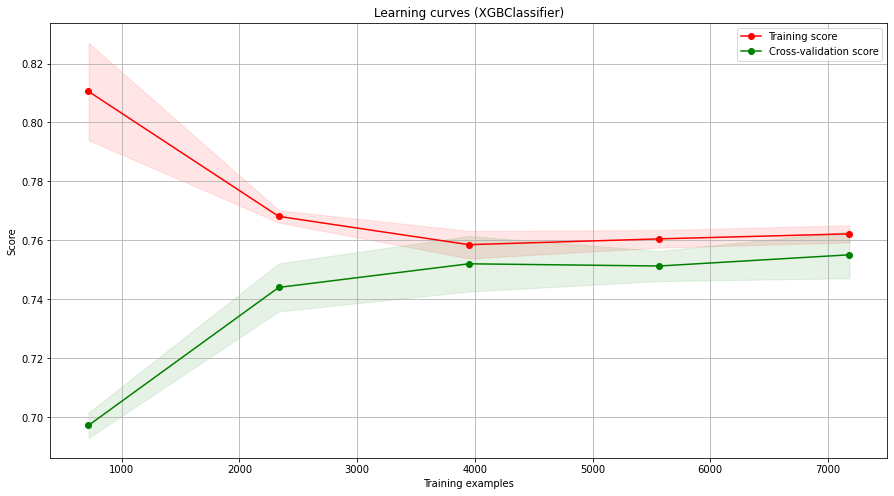

In [72]:
show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

In [73]:
y_test_pred_probs = model_xgb.predict_proba(X_test)
y_test_pred_probs

array([[0.34664506, 0.65335494],
       [0.56208944, 0.4379106 ],
       [0.6009887 , 0.3990113 ],
       ...,
       [0.4225871 , 0.5774129 ],
       [0.53285813, 0.46714184],
       [0.40262324, 0.59737676]], dtype=float32)

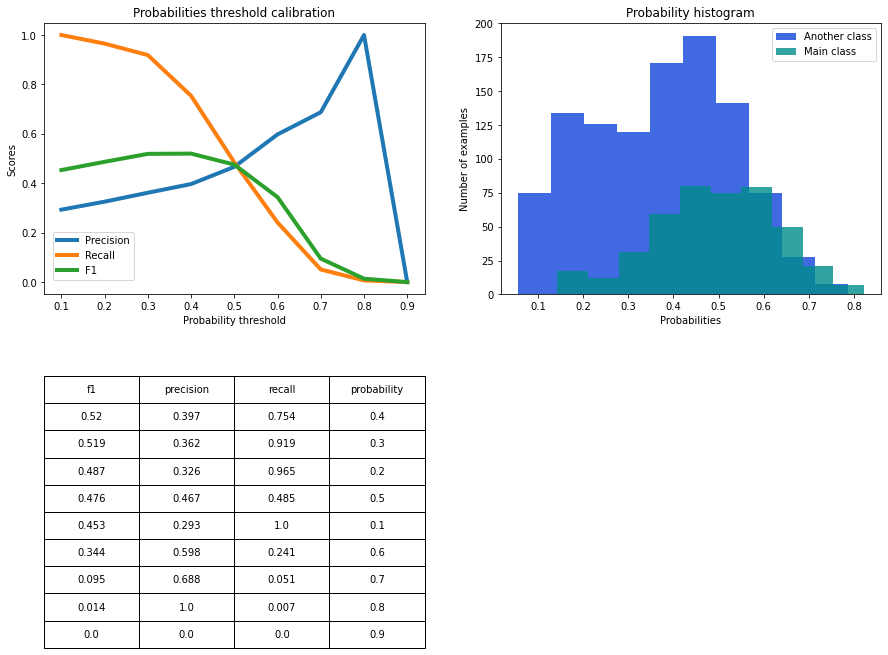

In [74]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

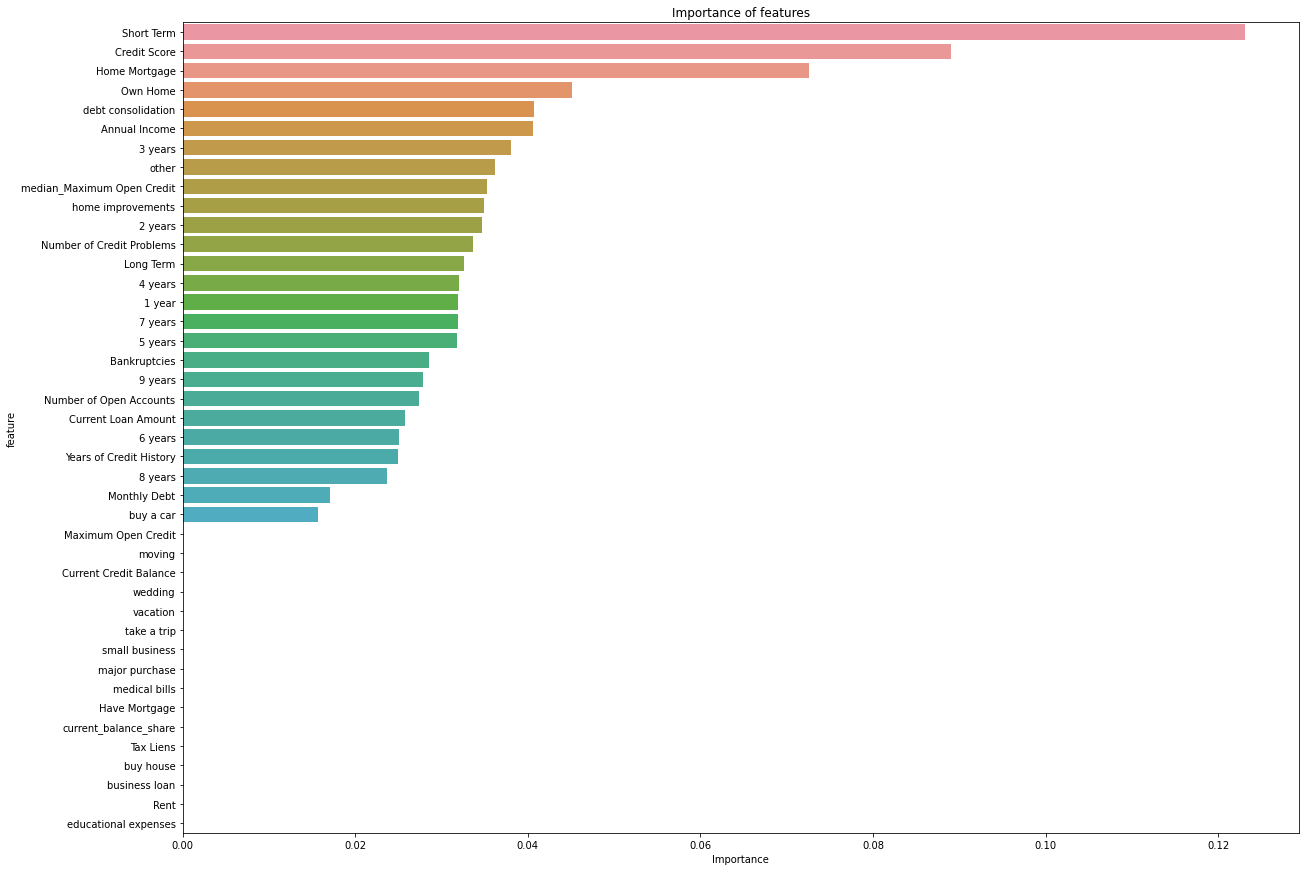

In [75]:
important_features_top = show_feature_importances(X_train_balanced.columns,
                                                  model_xgb.feature_importances_, get_top=20)

In [76]:
important_features_top

['Short Term',
 'Credit Score',
 'Home Mortgage',
 'Own Home',
 'debt consolidation',
 'Annual Income',
 '3 years',
 'other',
 'median_Maximum Open Credit',
 'home improvements',
 '2 years',
 'Number of Credit Problems',
 'Long Term',
 '4 years',
 '1 year',
 '7 years',
 '5 years',
 'Bankruptcies',
 '9 years',
 'Number of Open Accounts']

In [77]:
final_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=0.2
                              )
final_xgb.fit(X_train_balanced[important_features_top], y_train_balanced)

evaluate_preds(final_xgb,
               X_train_balanced[important_features_top],
               X_test[important_features_top],
               y_train_balanced,
               y_test)

[13:00:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.75      0.78      0.76      5387
           1       0.77      0.73      0.75      5387

    accuracy                           0.76     10774
   macro avg       0.76      0.76      0.76     10774
weighted avg       0.76      0.76      0.76     10774

TEST

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1069
           1       0.46      0.45      0.46       431

    accuracy                           0.69      1500
   macro avg       0.62      0.62      0.62      1500
weighted avg       0.69      0.69      0.69      1500

CONFUSION MATRIX

col_0

### Подготовка Catboost

In [78]:
X = df_train[BASE_FEATURE_NAMES]
y = df_train[TARGET_NAME]

# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     shuffle=True,
#                                                     test_size=0.1,
#                                                     random_state=21,
#                                                     stratify=y)

In [79]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features= CAT_FEATURE_NAMES,
                                     one_hot_max_size=3
                                     )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      4318
           1       0.91      0.58      0.71      1682

    accuracy                           0.87      6000
   macro avg       0.89      0.78      0.81      6000
weighted avg       0.87      0.87      0.86      6000

TEST

              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1069
           1       0.70      0.34      0.46       431

    accuracy                           0.77      1500
   macro avg       0.74      0.64      0.66      1500
weighted avg       0.76      0.77      0.74      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1007   62
1                283  148


In [80]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.56718192627824

In [81]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance]
                                     )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      4318
           1       0.70      0.91      0.79      1682

    accuracy                           0.87      6000
   macro avg       0.83      0.88      0.85      6000
weighted avg       0.89      0.87      0.87      6000

TEST

              precision    recall  f1-score   support

           0       0.81      0.74      0.77      1069
           1       0.47      0.57      0.51       431

    accuracy                           0.69      1500
   macro avg       0.64      0.65      0.64      1500
weighted avg       0.71      0.69      0.70      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               787  282
1               185  246


In [82]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     cat_features=CAT_FEATURE_NAMES,
                                     early_stopping_rounds=150,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall']
                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [83]:
model_catb.best_score_

{'learn': {'Recall:use_weights=false': 0.906064209274673,
  'Logloss': 0.5219241964676502,
  'F1': 0.767611462282328,
  'Precision:use_weights=false': 0.520648398301814,
  'Precision:use_weights=true': 0.736032701904412,
  'Recall:use_weights=true': 0.906064209274673},
 'validation': {'Recall:use_weights=false': 0.9002320185614849,
  'Logloss': 0.5809743522056374,
  'F1': 0.719825590451692,
  'Precision:use_weights=false': 0.44651162790697674,
  'Precision:use_weights=true': 0.6743735740009889,
  'Recall:use_weights=true': 0.9002320185614849}}

In [84]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.37      0.53      4318
           1       0.36      0.91      0.51      1682

    accuracy                           0.52      6000
   macro avg       0.63      0.64      0.52      6000
weighted avg       0.76      0.52      0.52      6000

TEST

              precision    recall  f1-score   support

           0       0.90      0.38      0.53      1069
           1       0.37      0.90      0.52       431

    accuracy                           0.53      1500
   macro avg       0.64      0.64      0.53      1500
weighted avg       0.75      0.53      0.53      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               404  665
1                43  388


In [85]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':150
}
model_catb = catb.CatBoostClassifier(**frozen_params)

In [86]:
params = {'iterations':[50, 200, 500, 700, 1500],
          'max_depth':[3, 5, 7]}

In [87]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [88]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6784650458
bestIteration = 49

0:	loss: 0.6784650	best: 0.6784650 (0)	total: 342ms	remaining: 4.79s

bestTest = 0.6899055776
bestIteration = 183

1:	loss: 0.6899056	best: 0.6899056 (1)	total: 1.19s	remaining: 7.75s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6906820357
bestIteration = 207

2:	loss: 0.6906820	best: 0.6906820 (2)	total: 3.07s	remaining: 12.3s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6906820357
bestIteration = 207

3:	loss: 0.6906820	best: 0.6906820 (2)	total: 4.75s	remaining: 13.1s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6906820357
bestIteration = 207

4:	loss: 0.6906820	best: 0.6906820 (2)	total: 6.14s	remaining: 12.3s

bestTest = 0.68029822
bestIteration = 47

5:	loss: 0.6802982	best: 0.6906820 (2)	total: 6.4s	remaining: 9.61s

bestTest = 0.6873979304
bestIteration = 129

6:	loss: 0.6873979	best: 0.6906820 (2)	total: 7.5s	remaining: 8.57s
Stopped by overfitting detector  (15

In [89]:
grid_search

{'params': {'depth': 3, 'iterations': 500},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
       

In [90]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

iterations  test-F1-mean  test-F1-std  train-F1-mean  train-F1-std  \
206         206      0.689335     0.016439       0.713704      0.007408   
83           83      0.689268     0.014604       0.699788      0.009471   
56           56      0.689252     0.014693       0.696006      0.010440   
203         203      0.688924     0.014592       0.713101      0.009165   
61           61      0.688903     0.014740       0.696865      0.010342   

     test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
206           0.598133          0.008999            0.577655   
83            0.615411          0.010390            0.606903   
56            0.626149          0.006990            0.619730   
203           0.598250          0.008899            0.578044   
61            0.623040          0.008240            0.616199   

     train-Logloss-std  
206           0.004372  
83            0.002914  
56            0.003819  
203           0.004384  
61            0.004517

In [91]:
%%time

final_model = catb.CatBoostClassifier(**frozen_params, iterations=200, max_depth=7)
final_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.38      0.54      4318
           1       0.36      0.90      0.52      1682

    accuracy                           0.53      6000
   macro avg       0.63      0.64      0.53      6000
weighted avg       0.75      0.53      0.53      6000

TEST

              precision    recall  f1-score   support

           0       0.90      0.39      0.54      1069
           1       0.37      0.89      0.52       431

    accuracy                           0.53      1500
   macro avg       0.63      0.64      0.53      1500
weighted avg       0.75      0.53      0.54      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               416  653
1                48  383
Wall time: 3.6 s


In [92]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=200,
                                max_depth=7, 
#                                 l2_leaf_reg=.5,
                                reg_lambda=0.2
                                )

model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.38      0.54      4318
           1       0.36      0.90      0.52      1682

    accuracy                           0.53      6000
   macro avg       0.63      0.64      0.53      6000
weighted avg       0.75      0.53      0.53      6000

TEST

              precision    recall  f1-score   support

           0       0.90      0.39      0.54      1069
           1       0.37      0.89      0.52       431

    accuracy                           0.53      1500
   macro avg       0.63      0.64      0.53      1500
weighted avg       0.75      0.53      0.54      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               416  653
1                48  383


In [93]:
params = {
    'reg_lambda': np.linspace(0.1, 4, 80)
}

In [94]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=200,
                                max_depth=7)

In [95]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [96]:
grid_search = model.randomized_search(params, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6821577694
bestIteration = 26

0:	loss: 0.6821578	best: 0.6821578 (0)	total: 1.72s	remaining: 1m 24s

bestTest = 0.6730940651
bestIteration = 95

1:	loss: 0.6730941	best: 0.6821578 (0)	total: 3.43s	remaining: 1m 22s

bestTest = 0.6667133267
bestIteration = 148

2:	loss: 0.6667133	best: 0.6821578 (0)	total: 5.29s	remaining: 1m 22s

bestTest = 0.6689361226
bestIteration = 61

3:	loss: 0.6689361	best: 0.6821578 (0)	total: 7.05s	remaining: 1m 21s

bestTest = 0.6792288408
bestIteration = 101

4:	loss: 0.6792288	best: 0.6821578 (0)	total: 8.77s	remaining: 1m 18s

bestTest = 0.6792196568
bestIteration = 60

5:	loss: 0.6792197	best: 0.6821578 (0)	total: 10.6s	remaining: 1m 17s

bestTest = 0.676958988
bestIteration = 60

6:	loss: 0.6769590	best: 0.6821578 (0)	total: 12.4s	remaining: 1m 15s

bestTest = 0.6747003952
bestIteration = 69

7:	loss: 0.6747004	best: 0.6821578 (0)	total: 13.9s	remaining: 1m 13s
Stopped by overfitting d

In [97]:
grid_search

{'params': {'l2_leaf_reg': 3.950632911392405},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
    

In [98]:
%%time

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.69      0.78      4318
           1       0.50      0.79      0.61      1682

    accuracy                           0.72      6000
   macro avg       0.70      0.74      0.70      6000
weighted avg       0.79      0.72      0.74      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.65      0.73      1069
           1       0.44      0.68      0.53       431

    accuracy                           0.66      1500
   macro avg       0.64      0.67      0.63      1500
weighted avg       0.72      0.66      0.68      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               699  370
1               139  292
Wall time: 628 ms


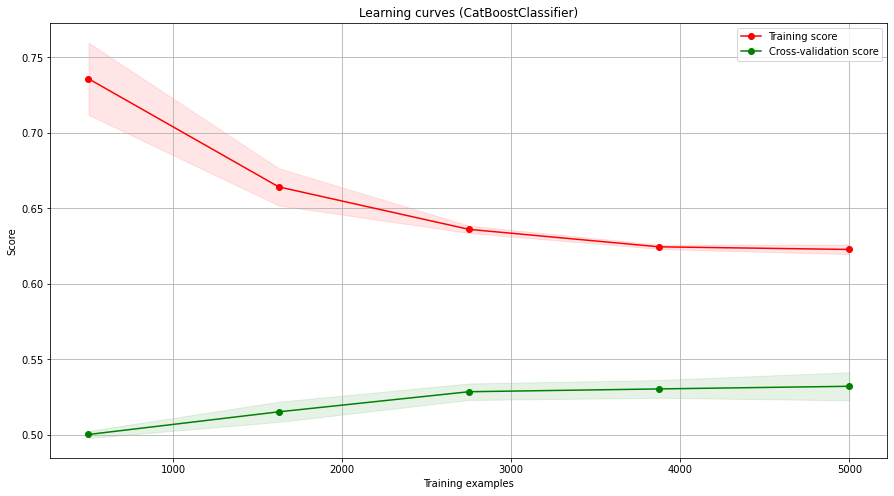

In [99]:
show_learning_curve_plot(model_catb, X, y)

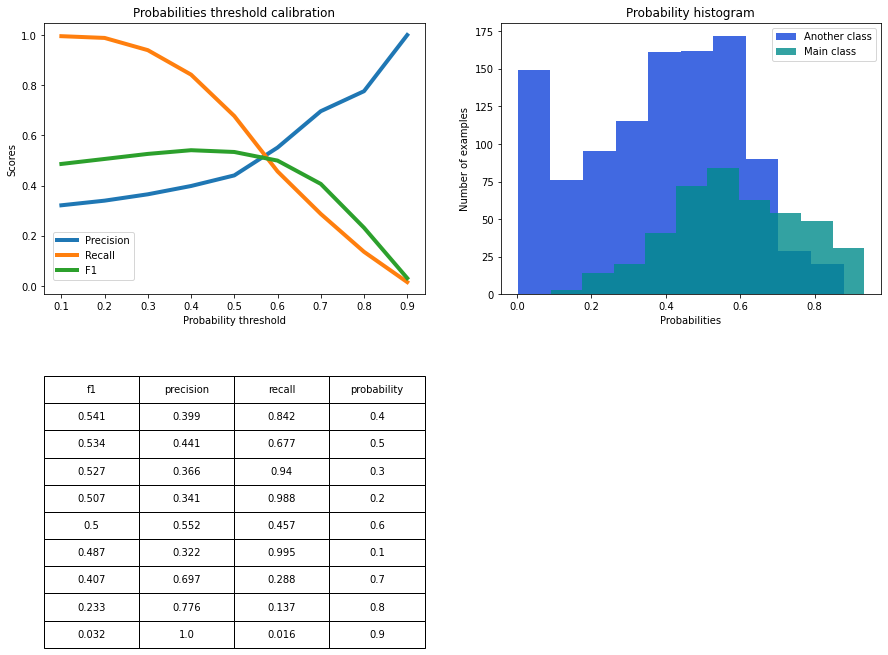

In [100]:
y_test_pred_probs = model_catb.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

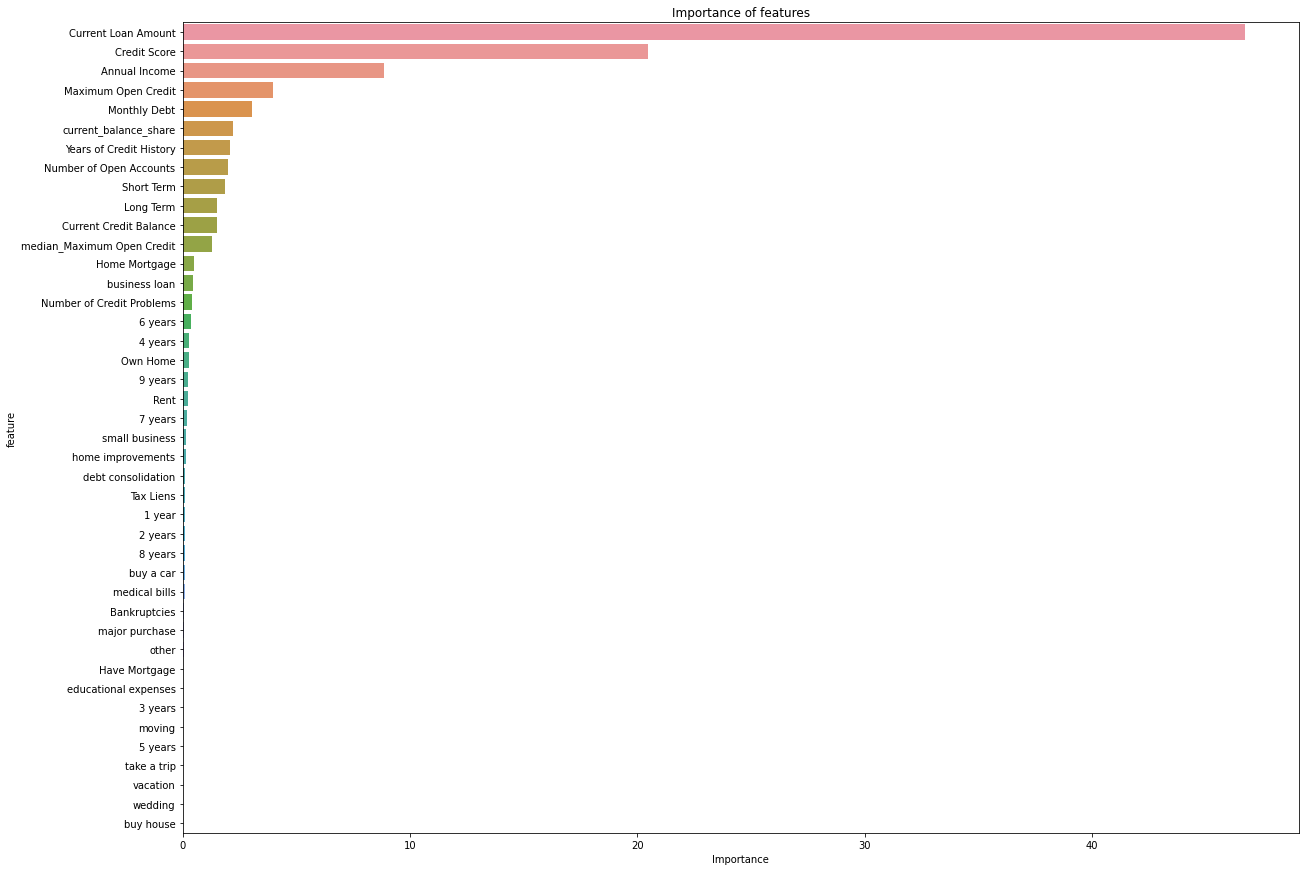

In [121]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=2)

In [122]:
important_features_top

['Current Loan Amount', 'Credit Score']

In [123]:
NEW_CAT_FEATURE_NAMES = list(set(CAT_FEATURE_NAMES).intersection(set(important_features_top)))
NEW_CAT_FEATURE_NAMES

[]

In [124]:
%%time

frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':NEW_CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':70
}

final_model = catb.CatBoostClassifier(**frozen_params,
                                      iterations=500,
                                      max_depth=3,
                                      reg_lambda=3.95)

final_model.fit(X_train[important_features_top], y_train)

evaluate_preds(final_model, X_train[important_features_top], X_test[important_features_top], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.63      0.72      4318
           1       0.43      0.73      0.54      1682

    accuracy                           0.65      6000
   macro avg       0.64      0.68      0.63      6000
weighted avg       0.74      0.65      0.67      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.61      0.70      1069
           1       0.42      0.70      0.52       431

    accuracy                           0.63      1500
   macro avg       0.62      0.65      0.61      1500
weighted avg       0.71      0.63      0.65      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               648  421
1               130  301
Wall time: 2.77 s


In [125]:
# X = df_test.drop(columns=['Home Ownership', '< 1 year','10+ years', 'Years in current job', 
#                                     'Purpose','Months since last delinquent', 'Term'])
# X = df_test[BASE_FEATURE_NAMES]
X = df_test[important_features_top]
# X = df_train[BASE_FEATURE_NAMES]

In [126]:
y_test_preds = final_model.predict(X)
# y_test_preds = model.predict(X)
# y_test_preds = model_svc.predict(X)
# y_test_preds = model_lr.predict(X)


In [127]:
d = {'Id': np.arange(2500), 'Credit Default': y_test_preds}
df2 = pd.DataFrame(data=d)
# df2['Credit Default'] = np.where(df2['Credit Default'] >= 0.25, 1, 0)
df2

Id  Credit Default
0        0               1
1        1               0
2        2               0
3        3               1
4        4               0
...    ...             ...
2495  2495               0
2496  2496               1
2497  2497               1
2498  2498               0
2499  2499               0

[2500 rows x 2 columns]

In [128]:
df2['Credit Default'].value_counts()

1    1256
0    1244
Name: Credit Default, dtype: int64

In [129]:
df2.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=',')